# Preparacion de datos

Este JupyterLab documenta el proceso de preparación y análisis de un conjunto de datos que contiene información sobre las transacciones registradas por la herramienta de transferencia de archivos GoAnywhere. El objetivo principal es realizar procesos de limpieza, estandarización, selección y adecuación de variables.

El conjunto de datos fue previamente sometido a un proceso de anonimización, con el fin de proteger información sensible como usuarios de conexión, direcciones IP/DNS de los servidores, rutas de archivo, áreas de negocio implicadas y acciones específicas sobre los archivos (como compresión/descompresión y encriptación/desencriptación).

Las principales actividades realizadas ente documento incluyen:

- Importación y estandarización de datos para validar coherencia y calidad en los registros.
- Agrupación de datos por ventanas de tiempo de 5 minutos.
- Visualizaciones de los datos para tener visión general del comportamiento de las transmisiones.

## Autor
- Juan Andrés Ruiz Ramírez      C.C. 1121712506
- Repositorio: https://github.com/juaruizra2/MFT_error_detection

## 1. Importación de Librerias y declaración de funciones

### 1.1 Importación de librerias

In [1]:
## Importación Librerias
# ==============================================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

#path carga de set de datos anonimizado
# ==============================================================================
path='./MFT_transfer_01-09-2025.csv'

### 1.2 Declaración funciones

In [60]:
def gf_barras(dataframe, columna, titulo, xlabel, ylabel):
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set(style="whitegrid")
    sns.set_context("talk", font_scale=1.3)

    # Aumentamos figura + margen superior para evitar choques
    plt.figure(figsize=(14, 8))
    plt.subplots_adjust(top=0.88)  # más espacio para títulos y labels

    ax = sns.countplot(
        data=dataframe,
        x=columna,
        palette="husl",
        linewidth=1,
        edgecolor="black"
    )

    total = len(dataframe)
    total_fmt = f"{total:,.0f}".replace(",", ".")

    percentages = []
    for p in ax.patches:
        count = p.get_height()
        percentages.append(100 * count / total)

    # Etiquetas en las barras con separación dinámica
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        height_fmt = f"{height:,.0f}".replace(",", ".")

        # Ajuste dinámico según la altura de la barra
        offset = height * 0.03  # separa más cuando la barra es más alta
        offset = max(offset, 0.5)  # que nunca sea menos de 0.5

        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + offset,
            f'{height_fmt}\n({percentages[i]:.1f}%)',
            ha='center',
            va='bottom',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

    # Título
    ax.set_title(
        f"{titulo} (Total: {total_fmt})",
        fontsize=22,
        fontweight='bold',
        pad=30  # espacio adicional para evitar colisión
    )

    # Ejes
    ax.set_xlabel(xlabel, fontsize=16, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=16)

    plt.xticks(fontsize=14, rotation=15)  # más limpio
    plt.yticks(fontsize=14)

    sns.despine(left=True)
    plt.tight_layout()

    plt.savefig(titulo + ".svg", format='svg', dpi=1200)
    plt.savefig(titulo+".jpg", bbox_inches='tight')
    plt.show()


In [3]:
#Funcion para realizar graficos de torta generico
def gf_torta(datos_filtrados, columna,titulo):

    # Filtrar los datos
    #datos_filtrados = data[data['type_transmission'] == 'recoleccion']
    
    # Contar la frecuencia de cada código de error
    conteo_errores = datos_filtrados[columna].value_counts()
    
    # Configurar el gráfico de pastel
    plt.figure(figsize=(10, 8))
    
    # Crear el gráfico con autopct para % y función personalizada para mostrar cantidad
    def formato_pastel(pct, valores):
        cantidad = int(round(pct/100.*sum(valores)))
        return f"{cantidad}\n({pct:.1f}%)"
    
    conteo_errores.plot(
        kind='pie',
        autopct=lambda pct: formato_pastel(pct, conteo_errores),
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 10}
    )
    
    # Añadir título y ajustar layout
    plt.title(titulo, pad=20)
    plt.ylabel("") 
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

In [4]:
#Funcion para realizar graficos de barra en escala logaritmica generica
def gf_barras_log(dataframe, columna, X, Y):
        
    # 1. Crear bins logarítmicos y agrupar los datos
    log_bins = [10**i for i in range(0, int(np.log10(dataframe[columna].max())) + 2)]
    dataframe[f'{columna}_grouped'] = pd.cut(dataframe[columna], bins=log_bins, include_lowest=True)
    
    # 3. Configurar el gráfico
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=dataframe, x=f'{columna}_grouped', palette='rocket')
    
    # 4. Añadir etiquetas duales (conteo + %)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{height}',  # Texto a mostrar (el conteo)
            (p.get_x() + p.get_width() / 2., height),  # Posición (centro de la barra)
            ha='center', va='center',  # Alineación horizontal/vertical
            xytext=(0, 5),  # Desplazamiento vertical del texto
            textcoords='offset points'  # Sistema de coordenadas
        )
    
    # 5. Personalización adicional
    plt.title(f'Distribución logarítmica: {columna}')
    plt.xlabel(X)
    plt.ylabel(Y)
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    dataframe.drop(columns=[f'{columna}_grouped'], inplace=True)

## 2. Carga y limpieza de los datos

- Se realiza la importación del conjunto de datos almacenado en el archivo "01_data_initial.csv". Es importante tener en cuenta que esta información será asignada a la variable "data", el cual corresponde a un objeto de tipo DataFrame de la biblioteca pandas, la cual permitirá su manipulación y análisis.

In [5]:
#Carga inicial de los datos
data = pd.read_csv(f"{path}")
type(data)

pandas.core.frame.DataFrame

In [6]:
#Vista de los 3 primeros registros del dataframe
data.head(3)

,type_transmission,date_start_transmission,date_end_transmission,error_code,num_files,files_size,origin_protocol,destination_protocol
0,recoleccion,2025-06-10 14:05:58.573,2025-06-10 14:05:58.596,NOK,0,0,smb,s3
1,recoleccion,2025-06-14 15:12:21.012,2025-06-14 15:12:22.999,PEN,0,0,smb,ssh
2,recoleccion,2025-06-14 15:12:18.478,2025-06-14 15:12:26.651,PEN,0,0,smb,ssh


In [7]:
# Información de las columnas del datafreme
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4905287 entries, 0 to 4905286
Data columns (total 8 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   type_transmission        object
 1   date_start_transmission  object
 2   date_end_transmission    object
 3   error_code               object
 4   num_files                int64 
 5   files_size               int64 
 6   origin_protocol          object
 7   destination_protocol     object
dtypes: int64(2), object(6)
memory usage: 299.4+ MB


In [8]:
# Cantidad de valores unicos de la columna "type_transmission"
data['type_transmission'].value_counts()

type_transmission
recoleccion    4007593
a_demanda       897694
Name: count, dtype: int64

In [9]:
# Cantidad de valores unicos de la columna "error_code"
data['error_code'].value_counts()

error_code
PEN    2622463
OK     2143084
NOK     139740
Name: count, dtype: int64

In [10]:
# Cantidad de valores unicos de la columna "num_files"
data['num_files'].value_counts()

num_files
 0       2601234
 1       1947408
-1         75075
 2         68409
 3         23138
          ...   
 2396          1
 1996          1
 1465          1
 1586          1
 2256          1
Name: count, Length: 1962, dtype: int64

In [11]:
data['num_files'].max()

np.int64(67046)

In [12]:
# Cantidad de valores unicos de la columna "files_size"
data['files_size'].value_counts()

files_size
0           2728933
342           29802
376           18158
6             15868
22            13507
             ...   
657616            1
176779            1
24018             1
84726             1
10905246          1
Name: count, Length: 349150, dtype: int64

In [13]:
data['files_size'].max()

np.int64(331925965673)

### Resumen de la sesión: Carga del conjunto de datos
En esta sesión se realizó la carga inicial del archivo "01_data_initial.csv", junto con una visualización preliminar del contenido y un resumen general del DataFrame.

A partir de la ejecución del método data.info(), se identificaron los siguientes aspectos clave:

- El conjunto de datos contiene 6 columnas relacionadas con las transacciones de transferencia de archivos.
- Las columnas "num_files" y "files_size" son de tipo "int64", lo cual es adecuado, ya que representan la cantidad de archivos transferidos y el tamaño de los archivos en bytes, respectivamente.
- La columna "files_size" representa el tamaño de archivos en bytes, lo que no facilita su comprensión, más adelante se realizará un escalado para que los valores queden en MB y sea más facil su interpretación.
- Las columnas "date_start_transmission" y "date_end_transmission" aparecen como tipo "object", lo cual indica un tipo de dato incorrecto. Estas columnas representan marcas de tiempo, por lo que deberán ser convertidas al tipo datetime.
- Existen solo dos valores en la columna "type_transmission", los cuales son: "recoleccion" y "a_demanda", esto indica que en la actualidad hay 2 modelos de transmision de archivos habilitados en la herramienta MFT.
- Existen solo tres valores en la columna "error_code", los cuales son:
    * "OK":  Ejecucion exitosa
    * "NOK": Ejecucion fallida
    * "PEN": Ejecucion sin archivos en el origen
- Para las columnas "num_files" y "files_size", se tiene gran cantidad de valores unicos, pero se puede interpretar al alto nivel que:
    * para "num_files": La mayor cantidad de archivos transmitidos en una transmision a sido de 41.171 archivos
    * para "files_size": El tamaño de archivos más grande transmitido es de 56116692484 bytes, lo que equivale a 56.11 GB

### 2.1 Modificación del tipo y escala de los datos

#### 2.1.1 Cambio Dtype columnas date
Como se identificó en la sesión anterior, es necesario modificar el tipo de dato de las columnas "date_start_transmission" y "date_end_transmission", ya que representan marcas de tiempo (fechas y horas) y actualmente están tipadas como "object", este cambio permitirá hacer operación sobre estas columnas.

In [14]:
# Cambiar tipo de datos de la columna date_start_transmission
data['date_start_transmission'] = pd.to_datetime(data['date_start_transmission'], format='%Y-%m-%d %H:%M:%S.%f')

In [15]:
# Cambiar tipo de datos de la columna date_end_transmission
data['date_end_transmission'] = pd.to_datetime(data['date_end_transmission'], format='%Y-%m-%d %H:%M:%S.%f')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4905287 entries, 0 to 4905286
Data columns (total 8 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   type_transmission        object        
 1   date_start_transmission  datetime64[ns]
 2   date_end_transmission    datetime64[ns]
 3   error_code               object        
 4   num_files                int64         
 5   files_size               int64         
 6   origin_protocol          object        
 7   destination_protocol     object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 299.4+ MB


#### 2.1.2 Cambio escala tamaño de archivos de bytes to MB
En la sesion anterior se percató que la manipulacion de bytes para el tamaño de archivos es poco practico, por ende se cambiara a unidades de MB los valores de la columna "files_size"

In [17]:
data['files_size_MB'] = data['files_size'] / (1024 * 1024)  # 1 MB = 1,048,576 bytes
data.drop(columns=['files_size'], inplace=True)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4905287 entries, 0 to 4905286
Data columns (total 8 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   type_transmission        object        
 1   date_start_transmission  datetime64[ns]
 2   date_end_transmission    datetime64[ns]
 3   error_code               object        
 4   num_files                int64         
 5   origin_protocol          object        
 6   destination_protocol     object        
 7   files_size_MB            float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 299.4+ MB


### 2.2 Generación nuevas columnas de datos

#### 2.2.1 Creacion columna "duration_transmission"

Dado que se cuenta con la marca de tiempo en el cual inicia la transferencia de archivos ("date_start_transmission") y cuando finaliza ("date_end_transmission"), puede que sea importante para el negocio el comprender como esta la duración de sus transmsiones. 
pdta: esta columna será informativa, solo para comprender un poco la tendencia de duración de las transmisiones y sus valores extremos, pero para identificar anomalias en el sistema no suma revelancia dado que el objetivo es determinar cuando la platafomra probablemente NO este habilitada para transmitir, independiente de la duracion que se tome la transmision.

In [19]:
# Se calcula la duracion de las transmisiones
data['duration_transmission'] = data['date_end_transmission'] - data['date_start_transmission']

In [20]:
# Las 10 transmisiones más rapidas
top_10_menos = data[data['error_code'] == 'OK'].nsmallest(10, 'duration_transmission')
print("Las 10 transferencias más rápidas (error_code = OK):")
print(top_10_menos[['type_transmission', 'duration_transmission','num_files','files_size_MB']])  # Mostrar columnas relevantes

Las 10 transferencias más rápidas (error_code = OK):
        type_transmission  duration_transmission  num_files  files_size_MB
104369          a_demanda 0 days 00:00:00.009000          1       0.000551
132112          a_demanda 0 days 00:00:00.009000          1       0.002450
192638          a_demanda 0 days 00:00:00.009000          1       0.001354
201708          a_demanda 0 days 00:00:00.009000          1       0.001354
433453          a_demanda 0 days 00:00:00.009000          1       0.000484
433456          a_demanda 0 days 00:00:00.009000          1       0.000484
2228099         a_demanda 0 days 00:00:00.009000          1       0.001511
2351301         a_demanda 0 days 00:00:00.009000          1       0.001214
2351436         a_demanda 0 days 00:00:00.009000          1       0.001214
2354007         a_demanda 0 days 00:00:00.009000          1       0.000474


In [21]:
# Las 10 transmisiones más demoradas
top_10_mas = data[data['error_code'] == 'OK'].nlargest(10, 'duration_transmission')
print("Las 10 transferencias más demorados (error_code = OK):")
print(top_10_mas[['type_transmission','duration_transmission','num_files','files_size_MB']])  # Mostrar columnas relevantes

Las 10 transferencias más demorados (error_code = OK):
        type_transmission  duration_transmission  num_files  files_size_MB
3239764       recoleccion 2 days 23:40:22.025000          1  316549.268411
807218          a_demanda 2 days 22:19:22.340000          1   78425.413671
3434976       recoleccion 2 days 16:27:42.063000          1  277670.167090
2661562         a_demanda 2 days 06:42:16.573000          1   57659.280975
2525646         a_demanda 1 days 19:13:01.204000          1   44715.052010
2296004         a_demanda 1 days 16:32:42.965000          1   48535.158600
1121725         a_demanda 1 days 16:23:40.748000          1   48535.158600
1117681         a_demanda 1 days 13:48:42.059000          1   43884.273213
3551340       recoleccion 1 days 08:36:18.348000      67046      33.843909
3985694       recoleccion 1 days 08:15:56.339000      67045      33.842939


### 2.3 Identificar y completar valores nulos

In [22]:
# realizar la sumatoria de valores nulos por columna
data.isnull().sum()

type_transmission                0
date_start_transmission          0
date_end_transmission            0
error_code                       0
num_files                        0
origin_protocol                  6
destination_protocol       1050106
files_size_MB                    0
duration_transmission            0
dtype: int64

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4905287 entries, 0 to 4905286
Data columns (total 9 columns):
 #   Column                   Dtype          
---  ------                   -----          
 0   type_transmission        object         
 1   date_start_transmission  datetime64[ns] 
 2   date_end_transmission    datetime64[ns] 
 3   error_code               object         
 4   num_files                int64          
 5   origin_protocol          object         
 6   destination_protocol     object         
 7   files_size_MB            float64        
 8   duration_transmission    timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(4), timedelta64[ns](1)
memory usage: 336.8+ MB


Nota: Dado que no se presentan valores nulos, por el tipo de negocio/naturaleza de la información no es necesario realizar algun tipo de analisis adicional

## 3. Primeras visualizaciones de los datos 

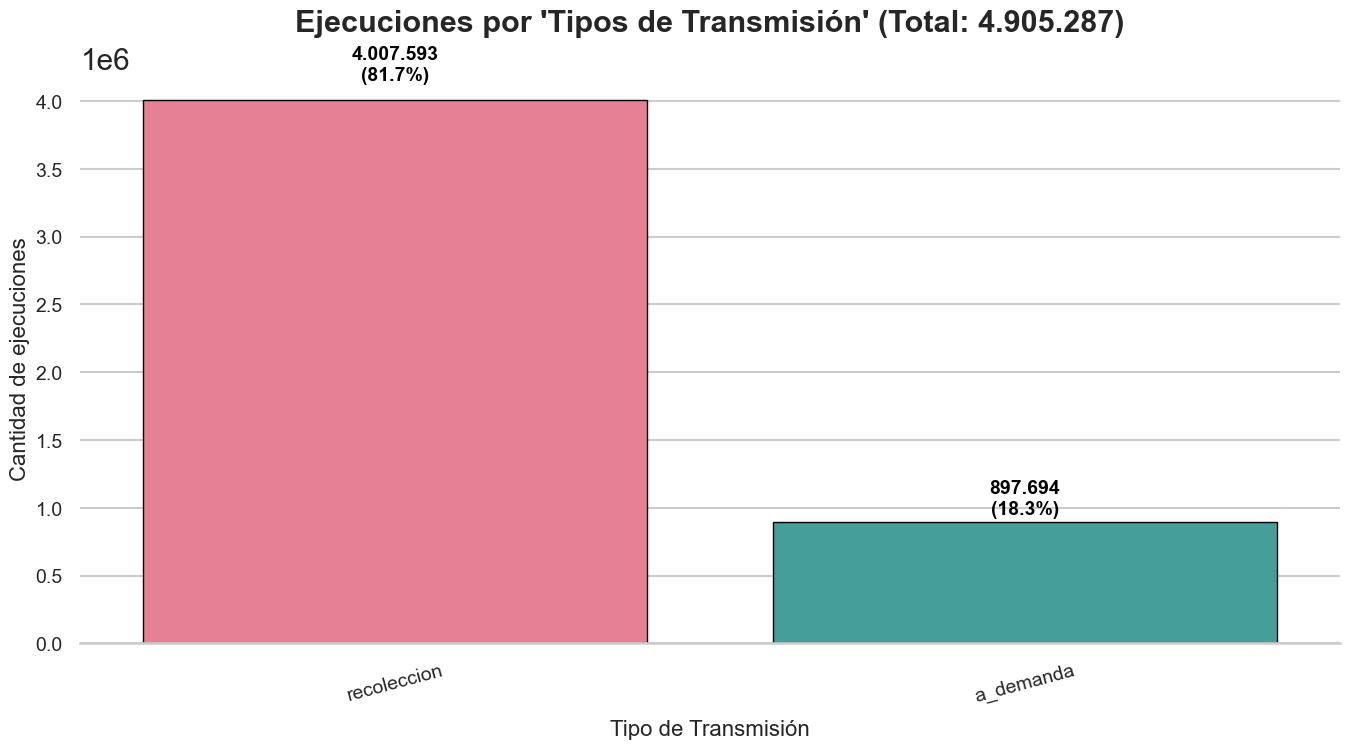

In [61]:
# Grafica de barra de las ejecuciones por tipo de transmision
gf_barras(data,"type_transmission","Ejecuciones por 'Tipos de Transmisión'","Tipo de Transmisión","Cantidad de ejecuciones")

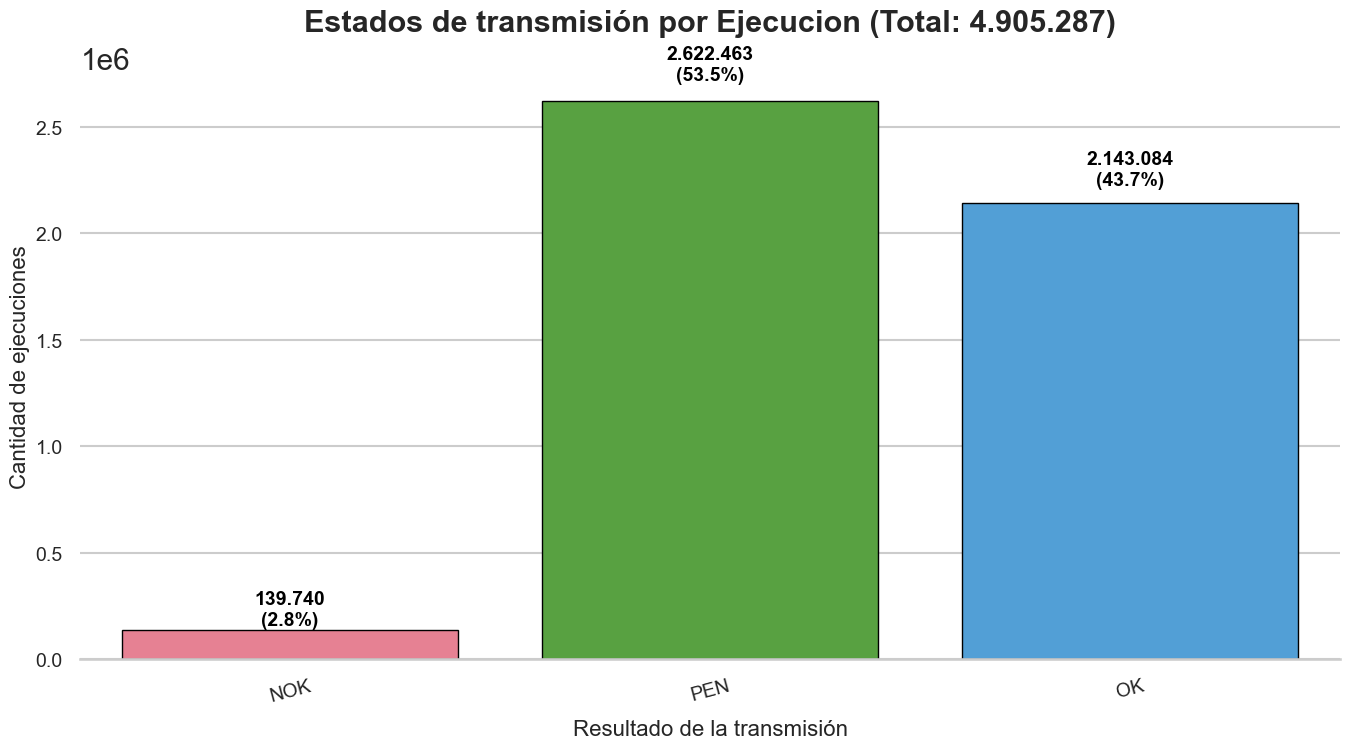

In [62]:
# Grafica de barra de las ejecuciones por tipo de transmision
gf_barras(data,"error_code","Estados de transmisión por Ejecucion","Resultado de la transmisión","Cantidad de ejecuciones")

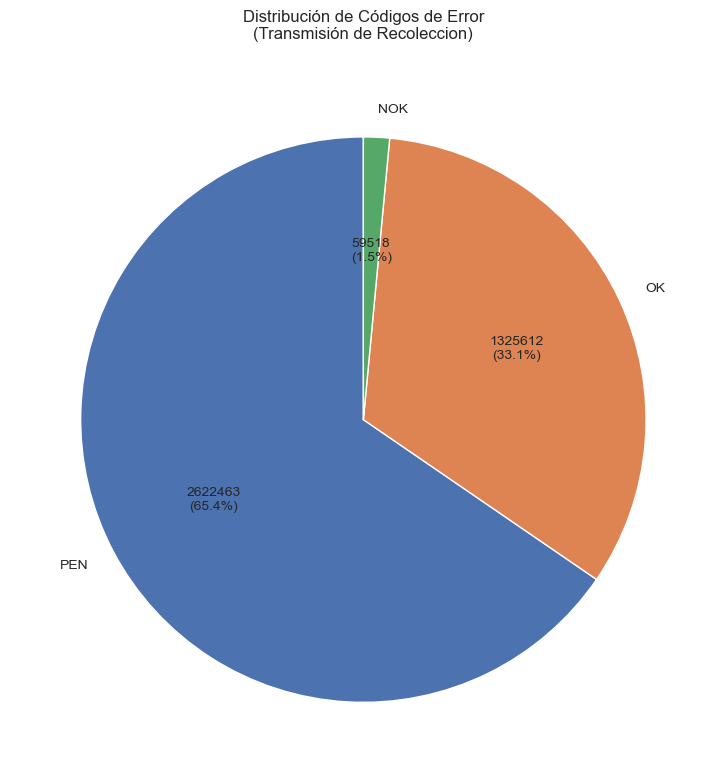

In [26]:
# Grafica de torta del tipo de estado resultante de las transmisiones de recoleccion
gf_torta(data[data['type_transmission'] == 'recoleccion'], 'error_code','Distribución de Códigos de Error\n(Transmisión de Recoleccion)')

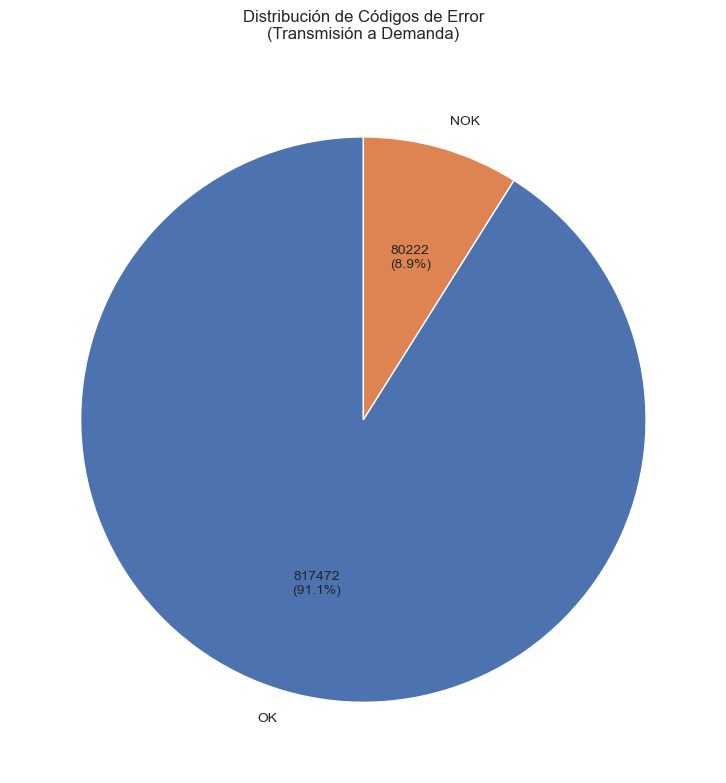

In [28]:
# Grafica de torta del tipo de estado resultante de las transmisiones de a_demanda
gf_torta(data[data['type_transmission'] == 'a_demanda'], 'error_code','Distribución de Códigos de Error\n(Transmisión a Demanda)')

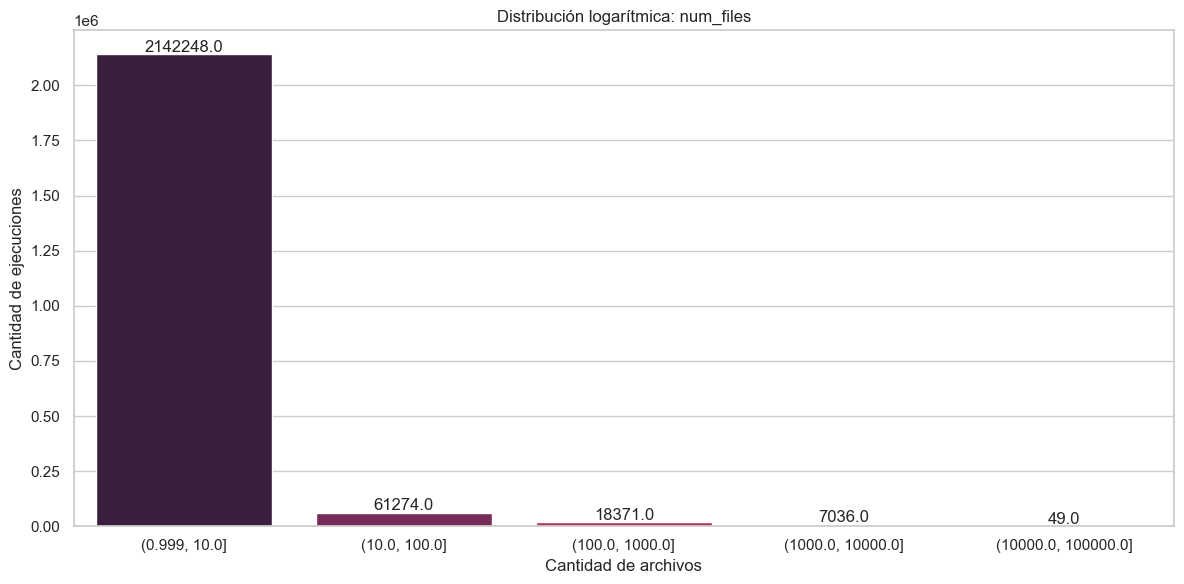

In [29]:
# Grafica de barras en escala logaritmica de cantidad de archivos transmitidos
gf_barras_log(data, 'num_files', 'Cantidad de archivos', 'Cantidad de ejecuciones')

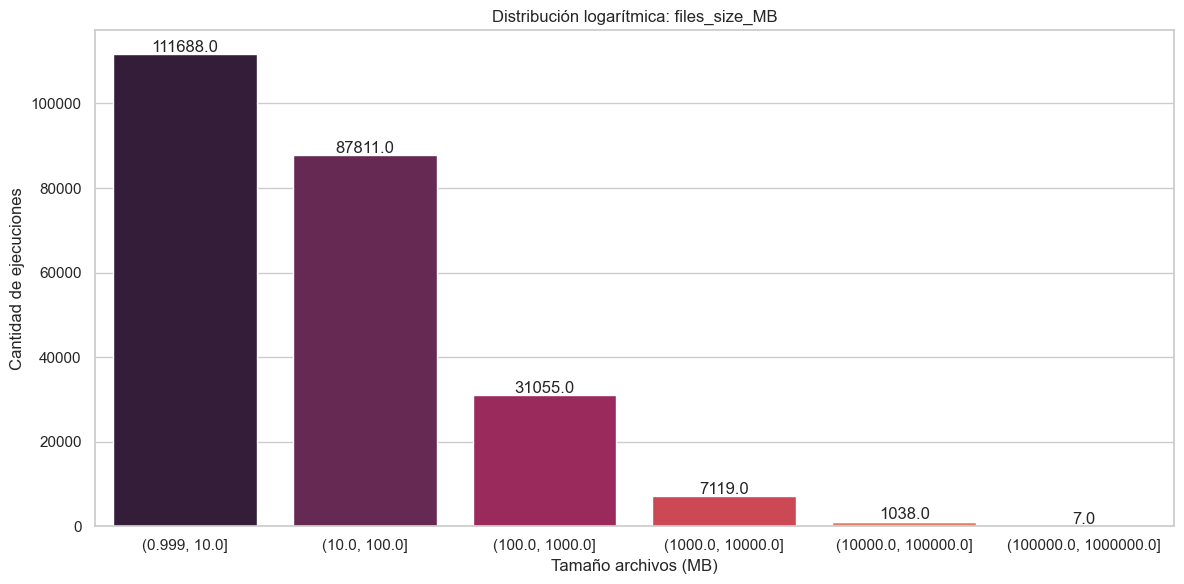

In [30]:
# Grafica de barras en escala logaritmica de tamaño (MB) de los archivos transmitidos
gf_barras_log(data, 'files_size_MB', 'Tamaño archivos (MB)', 'Cantidad de ejecuciones')

## 4. Agrupación datos por intervalo de tiempo
Para facilitar el analisis se realizará la agrupación por las transmisiones que hayan finalizado ("date_end_transmission") dentro del mismo intervalo de 5 minutos.
Para esto se requiere:
1. Ordenar los datos por la columna "date_end_transmission"
2. Agrupar por períodos de 5 minutos
3. Sumar la cantidad de ejecuciones OK/NOK/PEN durante ese intervalo (5 minutos)
4. Sumar la cantidad de archivos transmitidos en ese intervalo (5 minutos)
5. Sumar el tamaño de los archivos transmitidos en ese intervalo (5 minutos)
6. Sumar la cantidad de archivos transmitidos en modelo de "recoleccion" durante intervalos de 5 minutos
7. Sumar el tamaño de los archivos transmitidos en modelo "a demanda" durante intervalos de 5 minutos

### 4.1 Ordenar Dataframe por "date_end_transmission"

In [57]:
# 1. Setear el index y se orden
data_time = data.set_index('date_end_transmission').sort_index()
data_time.head(3)

,type_transmission,date_start_transmission,error_code,num_files,origin_protocol,destination_protocol,files_size_MB,duration_transmission
date_end_transmission,,,,,,,,
2025-06-06 00:00:04.129,recoleccion,2025-06-06 00:00:00.892,PEN,-1,ssh,ssh,0.000000,0 days 00:00:03.237000
2025-06-06 00:00:09.507,recoleccion,2025-06-06 00:00:09.192,PEN,0,smb,ssh,0.000000,0 days 00:00:00.315000
2025-06-06 00:00:12.600,a_demanda,2025-06-06 00:00:06.638,OK,1,ssh,NaN,0.043839,0 days 00:00:05.962000


In [58]:
data_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4905287 entries, 2025-06-06 00:00:04.129000 to 2025-09-01 02:08:54.806000
Data columns (total 8 columns):
 #   Column                   Dtype          
---  ------                   -----          
 0   type_transmission        object         
 1   date_start_transmission  datetime64[ns] 
 2   error_code               object         
 3   num_files                int64          
 4   origin_protocol          object         
 5   destination_protocol     object         
 6   files_size_MB            float64        
 7   duration_transmission    timedelta64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4), timedelta64[ns](1)
memory usage: 336.8+ MB


### 4.2  Crear grupos por intervalos de 5 minutos

In [35]:
# 2. Crear grupos por intervalos tiemmpo
interval='5T' #se define intervalo de 5minutos
grouped = data_time.groupby(pd.Grouper(freq=interval))

### 4.3 Realizar operaciones sobre dataframe

In [63]:
# 3. Definir las operaciones sobre las columbas, desagregar columnas por subcategorias
agg_dict = {
    'error_code': [
        ('OK', lambda x: (x == 'OK').sum()),
        ('NOK', lambda x: (x == 'NOK').sum()),
        ('PEN', lambda x: (x == 'PEN').sum())
    ],
    'type_transmission': [
        ('a_demanda', lambda x: (x == 'a_demanda').sum()),
        ('recoleccion', lambda x: (x == 'recoleccion').sum())
    ],
    'num_files': [('total', 'sum')],
    'files_size_MB': [('total', 'sum')]
}

In [64]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   type_transmission            2 non-null      object 
 1   error_code_OK                2 non-null      int64  
 2   error_code_NOK               2 non-null      int64  
 3   error_code_PEN               2 non-null      int64  
 4   num_files_total_files        2 non-null      int64  
 5   files_size_MB_total_size_MB  2 non-null      float64
dtypes: float64(1), int64(4), object(1)
memory usage: 228.0+ bytes


In [65]:
# 4. Aplicar las agregaciones
data_result = grouped.agg(agg_dict)

In [66]:
# 5. Aplanar el MultiIndex en columnas
data_result.columns = ['_'.join(col) for col in data_result.columns]

In [67]:
# 6. Rellenar intervalos faltantes
min_time = data_time.index.min().floor(interval)
max_time = data_time.index.max().ceil(interval)
full_range = pd.date_range(start=min_time, end=max_time, freq=interval)
data_result = data_result.reindex(full_range, fill_value=0)


In [68]:
data_result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25083 entries, 2025-06-06 00:00:00 to 2025-09-01 02:10:00
Freq: 5min
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   error_code_OK                  25083 non-null  int64  
 1   error_code_NOK                 25083 non-null  int64  
 2   error_code_PEN                 25083 non-null  int64  
 3   type_transmission_a_demanda    25083 non-null  int64  
 4   type_transmission_recoleccion  25083 non-null  int64  
 5   num_files_total                25083 non-null  int64  
 6   files_size_MB_total            25083 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 1.5 MB


In [69]:
data_result

,error_code_OK,error_code_NOK,error_code_PEN,type_transmission_a_demanda,type_transmission_recoleccion,num_files_total,files_size_MB_total
2025-06-06 00:00:00,36,2,100,22,116,141,112.412778
2025-06-06 00:05:00,35,0,5,21,19,50,2355.758350
2025-06-06 00:10:00,35,0,7,22,20,36,559.763928
2025-06-06 00:15:00,51,0,16,20,47,50,2270.194889
2025-06-06 00:20:00,52,0,18,23,47,47,1001.247231
...,...,...,...,...,...,...,...
2025-09-01 01:50:00,0,0,0,0,0,0,0.000000
2025-09-01 01:55:00,0,0,0,0,0,0,0.000000
2025-09-01 02:00:00,0,0,0,0,0,0,0.000000
2025-09-01 02:05:00,0,1,0,1,0,1,0.000000


In [70]:
#Almacenar archivo depurado y organizado
data_result.to_csv('02_data_prepared.csv', index=True, header=True)

### Resumen de la sesión: Agrupación por intervalo de tiempo
En esta sesión se realizó la agrupación de los registros por ventanas de tiempo de 5 minutos, la intención de esto es agrupar toda la información obtenida de cada transferencia y agruparla por intervalos fijos. Esto hizo que se organizara los registros en base a su timestamp de finalizacion y se sumara sus datos (tamaños de archivos, cantidad de archivos, escenario de archivo) ejecutado durante dicho intervalo. el resultado es un nuevo dataframe del cual se almaceno su data en el archivo "02_data_prepared.csv".

Tambien es importante resaltar que se crearon las columnas en el nuevo dataframe: 

- error_code_OK: int64, indica la cantidad de transferencias ejecutadas con estado "OK" en el intervalo de tiempo
- error_code_NOK: int64, indica la cantidad de transferencias ejecutadas con estado "NOK" en el intervalo de tiempo
- error_code_PEN: int64, indica la cantidad de transferencias ejecutadas con estado "PEN" en el intervalo de tiempo
- type_transmission_a_demanda: int64, indica la cantidad de transferencias ejecutadas del modelo "a_demanda" en el intervalo de tiempo
- type_transmission_recoleccion: int64, indica la cantidad de transferencias ejecutadas del modelo "recoleccion" en el intervalo de tiempo
- num_files_total: int64, indica la cantidad de archivos transferidos en el intervalo de tiempo
- files_size_MB_total: float64, indica el tamaño de los archivos transferidos en el intervalo de tiempo

Se ignoraron las siguientes columnas del dataframe original:
- type_transmission: object, dado que se crearon 2 nuevas columnas de tipo numerica con la cantidad de transmisiones ejecutadas en el intervalo de tiempo por "type_transmission"
- date_start_transmission: datetime64, dado que solamente se concideró "date_end_transmission" como referencia de tiempo para el analisis del comportamiento de la data por que los registros iniciales son registrados solo cuando la transmision es finalizada, es decir, las transmisiones que no se pueden ejecutar (por indisponibilidad del sistema) NO aparecen registradas.
- error_code: object, dado que se crearon 3 nuevas columnas de tipo numerica con la cantidad de transmisiones ejecutadas en el intervalo de tiempo por "error_code"
- num_files: int64, dado que se creo una nueva columna de tipo numerica donde se registra el acumulado de cantidad de archivos transmitidos.
- files_size_MB: float64, dado que se creo una nueva columna de tipo numerica donde se registra el tamaño acumulado de archivos transmitidos.
- duration_transmission: timedelta64, esta información fue más a nivel de negocio que se generó pero no contribuye al analisis de la indisponibilidad de la herramienta, dado que lo que interesa es la cantidad de ejecuciones y no la duracion de las transmisiones.

Se conservaron/transformaron las siguientes columnas del dataframe original:
- date_end_transmission: datetime64, se ordenaron los registros del dataframe de forma ascendente en la linea de tiempo y se asigno como indice al dataframe nuevo


## 5. Visualizaciones de datos por ventanas de tiempo

### 5.1 Estado de transmisiones por dia de semana 

In [71]:
# Extraer el día de la semana del índice DateTime (0=lunes, 6=domingo)
data_result['dia_semana'] = data_result.index.dayofweek

# Agrupar por día de la semana y calcular la suma de cada código de error
error_por_dia_semana = data_result.groupby('dia_semana')[['error_code_OK', 'error_code_NOK', 'error_code_PEN']].sum()

# Mapear números de día a nombres
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
error_por_dia_semana.index = dias

# Calcular totales y porcentajes
total_por_dia = error_por_dia_semana.sum(axis=1)
porcentajes = error_por_dia_semana.div(total_por_dia, axis=0) * 100

<Figure size 1200x600 with 0 Axes>

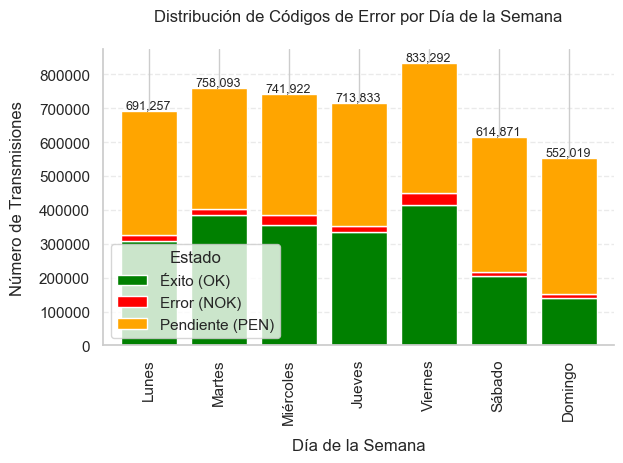

In [72]:
plt.figure(figsize=(12, 6))
ax = error_por_dia_semana.plot(kind='bar', stacked=True, color=['green', 'red', 'orange'], width=0.8)

plt.title('Distribución de Códigos de Error por Día de la Semana', pad=20)
plt.xlabel('Día de la Semana', labelpad=10)
plt.ylabel('Número de Transmisiones', labelpad=10)
plt.legend(['Éxito (OK)', 'Error (NOK)', 'Pendiente (PEN)'], title='Estado')

# Añadir etiquetas con el total por día
for i, total in enumerate(total_por_dia):
    ax.text(i, total, f'{total:,}', ha='center', va='bottom', fontsize=9)

# Personalizar ejes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

###  5.2 Gráfico de Transmisiones Totales por Hora

In [73]:
# Extraer la hora del índice temporal
data_result['hora'] = data_result.index.hour

# Calcular total de transmisiones por intervalo
data_result['total_transmisiones'] = data_result['error_code_OK'] + data_result['error_code_NOK'] + data_result['error_code_PEN']

# Agrupar por hora y calcular estadísticas
transmisiones_por_hora = data_result.groupby('hora')['total_transmisiones'].agg(['sum', 'mean', 'count'])

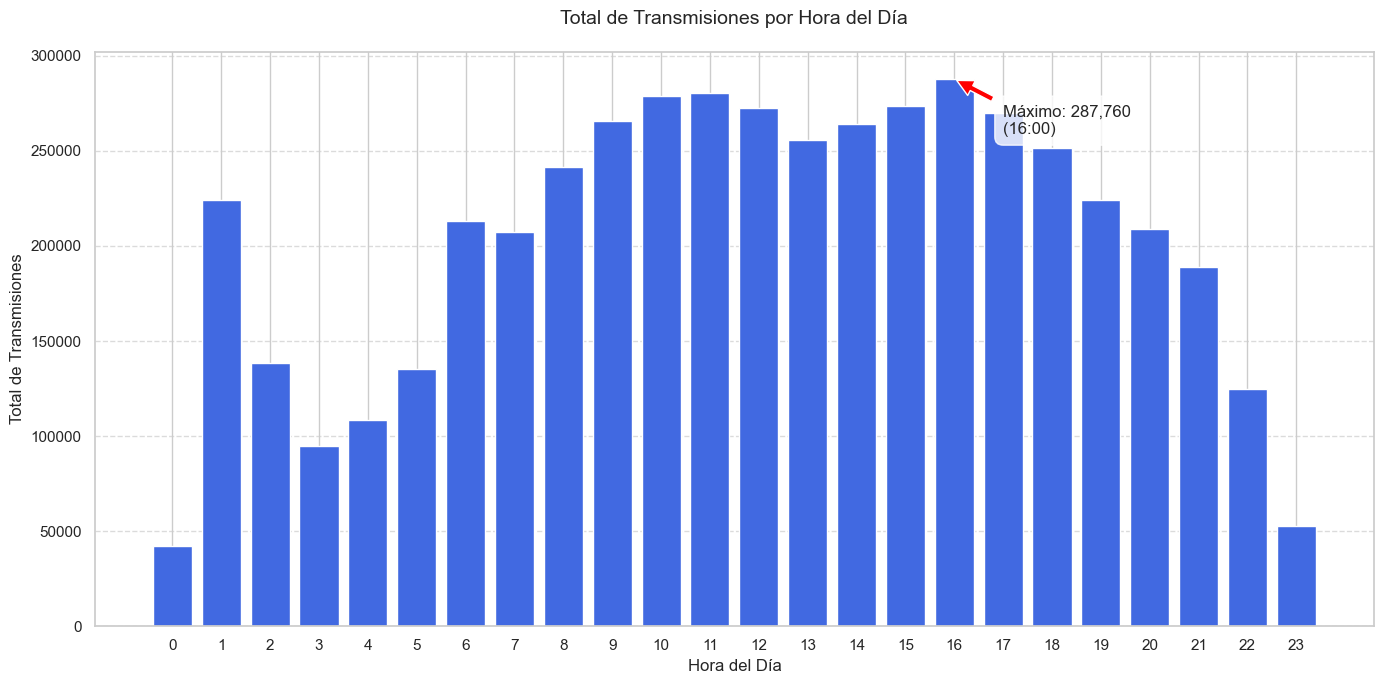

In [74]:
plt.figure(figsize=(14, 7))
plt.bar(transmisiones_por_hora.index, transmisiones_por_hora['sum'], color='royalblue')

plt.title('Total de Transmisiones por Hora del Día', pad=20, fontsize=14)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Total de Transmisiones', fontsize=12)
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Destacar las horas pico
max_hora = transmisiones_por_hora['sum'].idxmax()
max_valor = transmisiones_por_hora['sum'].max()
plt.annotate(f'Máximo: {max_valor:,}\n({max_hora}:00)', 
             xy=(max_hora, max_valor), 
             xytext=(max_hora+1, max_valor*0.9),
             arrowprops=dict(facecolor='red', shrink=0.05),
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.tight_layout()
plt.show()

###  5.3 Gráfico de Transmisiones Promedio por Hora

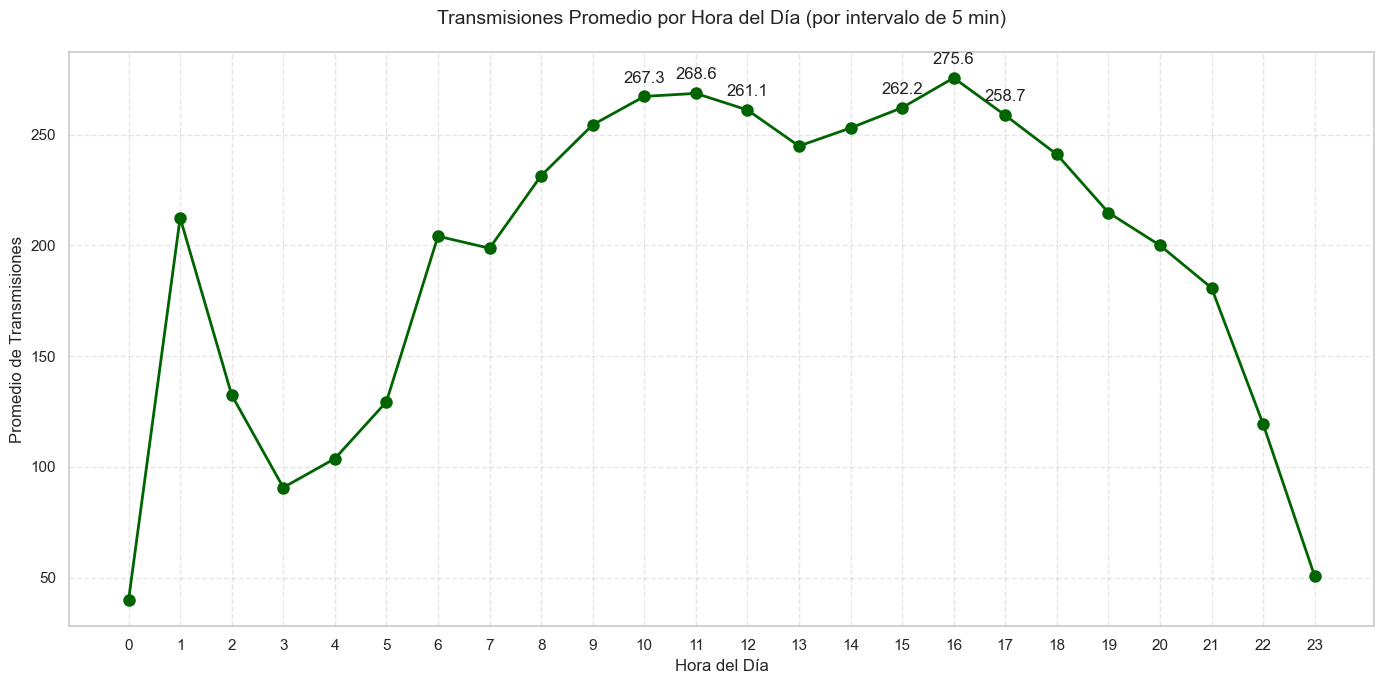

In [75]:
plt.figure(figsize=(14, 7))
plt.plot(transmisiones_por_hora.index, transmisiones_por_hora['mean'], 
         marker='o', color='darkgreen', linewidth=2, markersize=8)

plt.title('Transmisiones Promedio por Hora del Día (por intervalo de 5 min)', pad=20, fontsize=14)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Promedio de Transmisiones', fontsize=12)
plt.xticks(range(24))
plt.grid(True, linestyle='--', alpha=0.5)

# Marcar horas importantes
for hora in transmisiones_por_hora.index:
    if transmisiones_por_hora['mean'][hora] > transmisiones_por_hora['mean'].quantile(0.75):
        plt.annotate(f'{transmisiones_por_hora["mean"][hora]:.1f}', 
                    (hora, transmisiones_por_hora["mean"][hora]),
                    textcoords="offset points", 
                    xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

###  5.4 Gráfico de Calor por Hora y Día de la Semana

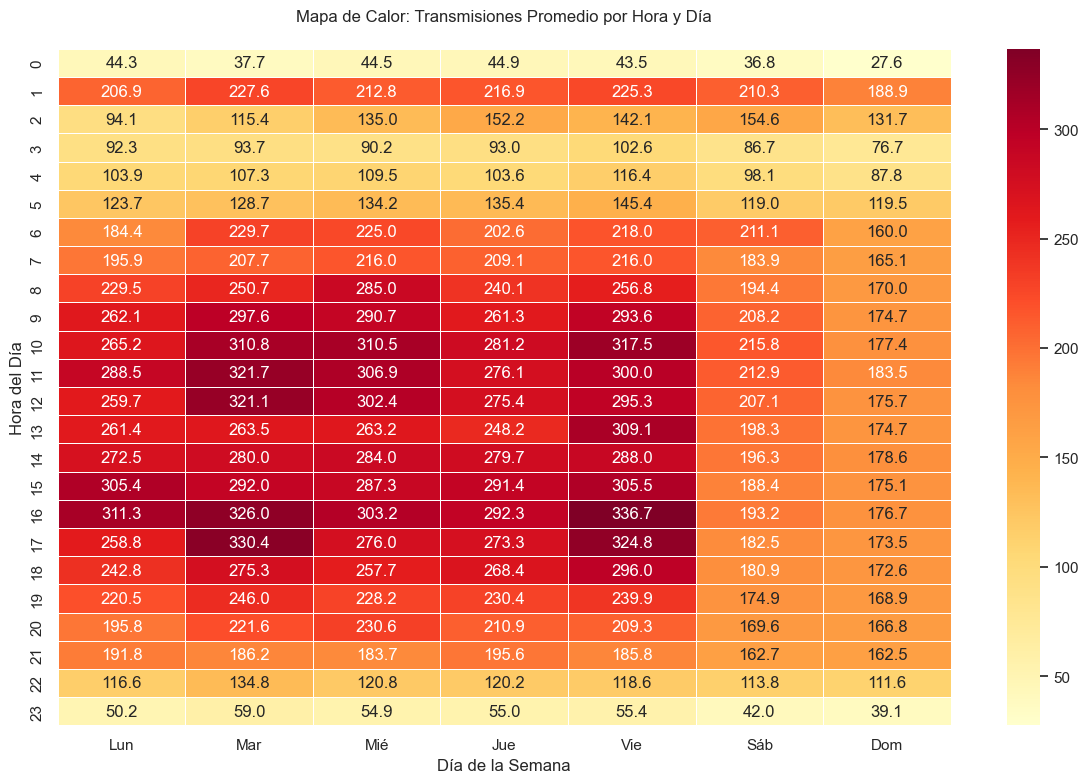

In [76]:
# Crear matriz de horas vs días de semana
transmisiones_hora_dia = data_result.pivot_table(
    index='hora',
    columns='dia_semana',
    values='total_transmisiones',
    aggfunc='mean'
)

# Mapear números de día a nombres
dias_semana = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
transmisiones_hora_dia.columns = dias_semana

plt.figure(figsize=(12, 8))
sns.heatmap(transmisiones_hora_dia, cmap='YlOrRd', annot=True, fmt='.1f', linewidths=.5)
plt.title('Mapa de Calor: Transmisiones Promedio por Hora y Día', pad=20)
plt.xlabel('Día de la Semana')
plt.ylabel('Hora del Día')
plt.tight_layout()
plt.show()

###  5.5 Gráfico Combinado (Promedio + Percentiles)

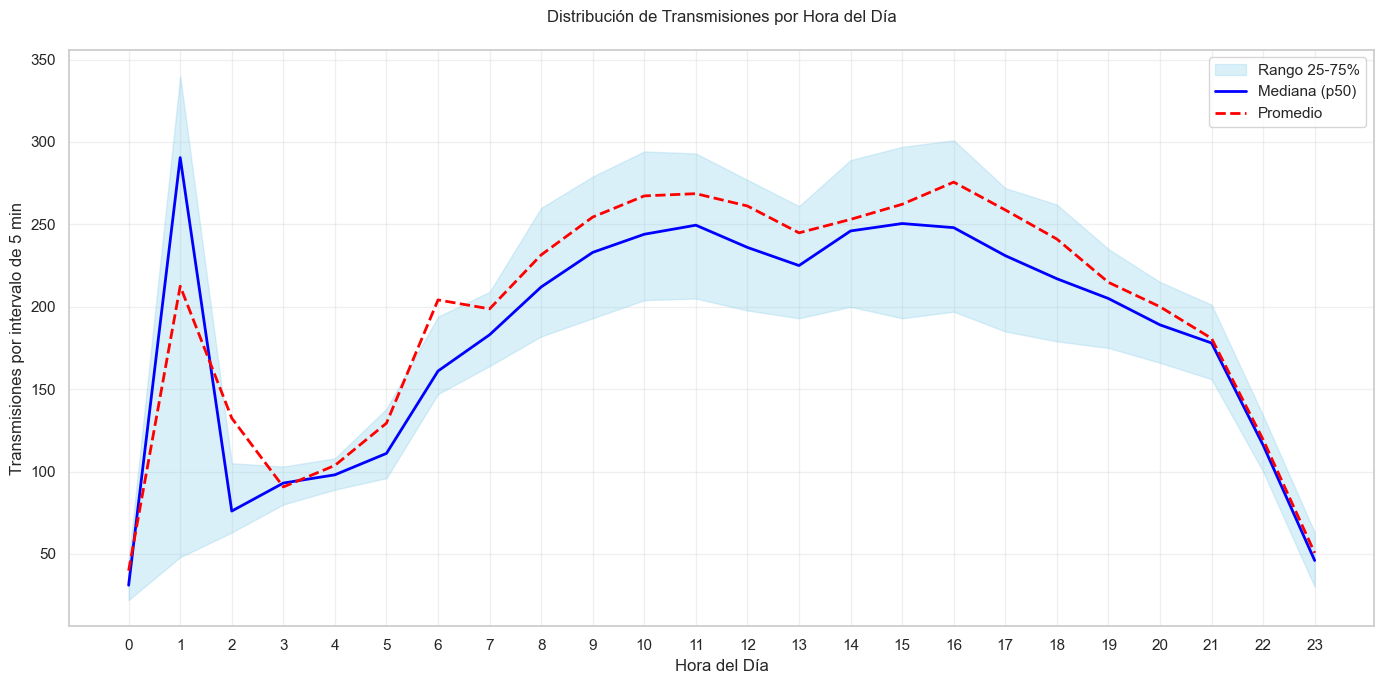

In [77]:
# Calcular percentiles por hora
percentiles = data_result.groupby('hora')['total_transmisiones'].agg(
    p25=lambda x: x.quantile(0.25),
    p50=lambda x: x.quantile(0.5),
    p75=lambda x: x.quantile(0.75)
)

plt.figure(figsize=(14, 7))
plt.fill_between(percentiles.index, percentiles['p25'], percentiles['p75'], 
                 color='skyblue', alpha=0.3, label='Rango 25-75%')
plt.plot(percentiles.index, percentiles['p50'], 
         color='blue', linewidth=2, label='Mediana (p50)')
plt.plot(transmisiones_por_hora.index, transmisiones_por_hora['mean'], 
         color='red', linestyle='--', linewidth=2, label='Promedio')

plt.title('Distribución de Transmisiones por Hora del Día', pad=20)
plt.xlabel('Hora del Día')
plt.ylabel('Transmisiones por intervalo de 5 min')
plt.xticks(range(24))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

###  5.6 Resumen Numerico

In [78]:
#Semanas
print("\n--- Estadísticas por Día de la Semana ---")
# Cuenta días con al menos un registro
print(f"Total Días con registros: {data_result.resample('D').size().astype(bool).sum()}")
print(f"Total de transmisiones analizadas: {error_por_dia_semana.sum().sum():,}")


print("\nDías con:")
print(f"Mayor éxito: {error_por_dia_semana['error_code_OK'].idxmax()} ({error_por_dia_semana['error_code_OK'].max():,})")
print(f"Mayor error: {error_por_dia_semana['error_code_NOK'].idxmax()} ({error_por_dia_semana['error_code_NOK'].max():,})")
print(f"Mayor pendientes: {error_por_dia_semana['error_code_PEN'].idxmax()} ({error_por_dia_semana['error_code_PEN'].max():,})")

print("\nTasa promedio de éxito:", f"{porcentajes['error_code_OK'].mean():.1f}%")
print("Tasa promedio de error:", f"{porcentajes['error_code_NOK'].mean():.1f}%")
print("Tasa promedio de pendientes:", f"{porcentajes['error_code_PEN'].mean():.1f}%")

#Horas
print("\n--- Estadísticas por Hora del Día ---")
print(f"Hora con mayor volumen total: {transmisiones_por_hora['sum'].idxmax()}:00")
print(f"Hora con mayor promedio: {transmisiones_por_hora['mean'].idxmax()}:00")
print("\nTop 5 horas con más transmisiones:")
print(transmisiones_por_hora['sum'].sort_values(ascending=False).head(5))
print("\nTop 5 horas con menos transmisiones:")
print(transmisiones_por_hora['sum'].sort_values().head(5))

# Calcular diferencia entre hora pico y valle
diferencia = transmisiones_por_hora['sum'].max() / transmisiones_por_hora['sum'].min()
print(f"\nDiferencia entre hora pico y valle: {diferencia:.1f} veces")


--- Estadísticas por Día de la Semana ---
Total Días con registros: 88
Total de transmisiones analizadas: 4,905,287

Días con:
Mayor éxito: Viernes (414,947)
Mayor error: Viernes (34,995)
Mayor pendientes: Domingo (400,576)

Tasa promedio de éxito: 42.7%
Tasa promedio de error: 2.8%
Tasa promedio de pendientes: 54.6%

--- Estadísticas por Hora del Día ---
Hora con mayor volumen total: 16:00
Hora con mayor promedio: 16:00

Top 5 horas con más transmisiones:
hora
16    287760
11    280456
10    279027
15    273720
12    272637
Name: sum, dtype: int64

Top 5 horas con menos transmisiones:
hora
0      42040
23     52835
3      94644
4     108262
22    124573
Name: sum, dtype: int64

Diferencia entre hora pico y valle: 6.8 veces


###  5.7 Resumen de la sesión: Visualizacion data

- Los datos dan una vision general del comportamiento de la herramienta MFT transaccional, donde se identifica las horas del dia con mayor transaccionalidad (16,15,14,1 y 10 horas respectivamente) y los dias con más trafico (martes)
- Hay que resaltar que la cantidad de transferencias realizadas (independiente de su resultado, es decir, suma de los valores de error_code_OK, error_code_NOK y error_code_PEN) por cada intervalo de 5 minutos es la variable objetivo para los modelos de machine learning.
- Tambien es importante tener en cuenta el grafico de percentiles por que da un intervalo de ejecuciones por dia/hora, y este intervalo de "tolerancia" es necesario para no generar falsos alertamientos en caso de que la cantidad de transaccion de un dia este bajo.
- Es importante seguir registrando más dias de datos, dado que solo se incluye un dia 15, un dia 30 y un 1 de mes, dias en donde la transaccionalidad es más critica para el negocio.
